In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import mlxtend



In [3]:
# load data
df2009_2010 = pd.read_csv("year2009-2010.csv", encoding="latin1")
df2010_2011 = pd.read_csv("year2010-2011.csv", encoding="latin1")

# rename invoice column
df2009_2010.rename(columns={df2009_2010.columns[0]: 'Invoice'}, inplace=True)
df2010_2011.rename(columns={df2010_2011.columns[0]: 'Invoice'}, inplace=True)

# remove non-customer transactions
df2010_2011 = df2010_2011.dropna(subset=['Customer ID'])
df2009_2010 = df2009_2010.dropna(subset=['Customer ID'])

#combine duplicate transactions
df2009_2010 = df2009_2010.groupby(['Invoice', 'StockCode', 'Customer ID'], as_index=False).agg({
    'Quantity': 'sum',
    'InvoiceDate': 'first',
    'Price': 'first',
    'Description': 'first',  
    'Country': 'first'       
})
df2010_2011 = df2010_2011.groupby(['Invoice', 'StockCode', 'Customer ID'], as_index=False).agg({
    'Quantity': 'sum',
    'InvoiceDate': 'first',
    'Price': 'first',
    'Description': 'first',  
    'Country': 'first'       
})

# add time features 
df2009_2010['InvoiceDate'] = pd.to_datetime(df2009_2010['InvoiceDate'])
df2009_2010['TimeOfDay'] = df2009_2010['InvoiceDate'].dt.hour
df2009_2010['DayOfWeek'] = df2009_2010['InvoiceDate'].dt.day_name()
df2010_2011['InvoiceDate'] = pd.to_datetime(df2010_2011['InvoiceDate'])
df2010_2011['TimeOfDay'] = df2010_2011['InvoiceDate'].dt.hour
df2010_2011['DayOfWeek'] = df2010_2011['InvoiceDate'].dt.day_name()

# calculate session duration
df2009_2010['SessionDuration'] = df2009_2010.groupby('Customer ID')['InvoiceDate'].diff().dt.total_seconds()
df2010_2011['SessionDuration'] = df2010_2011.groupby('Customer ID')['InvoiceDate'].diff().dt.total_seconds()

# calculate total sales amount
df2009_2010['TotalSalesAmount'] = df2009_2010['Quantity'] * df2009_2010['Price']
df2010_2011['TotalSalesAmount'] = df2010_2011['Quantity'] * df2010_2011['Price']

# revenue
df2009_2010['Revenue'] = df2009_2010['Quantity'] * df2009_2010['Price']
df2010_2011['Revenue'] = df2010_2011['Quantity'] * df2010_2011['Price']

# combine 2009-2010 and 2010-2011
df = pd.concat([df2009_2010, df2010_2011])

# split into purchases and returns
df_purchases = df[df['Quantity'] > 0]
df_returns = df[df['Quantity'] < 0]

                 Country
0              Australia
1                Austria
2                Bahrain
3                Belgium
4                 Brazil
5                 Canada
6        Channel Islands
7                 Cyprus
8         Czech Republic
9                Denmark
10                  EIRE
11    European Community
12               Finland
13                France
14               Germany
15                Greece
16               Iceland
17                Israel
18                 Italy
19                 Japan
20                 Korea
21               Lebanon
22             Lithuania
23                 Malta
24           Netherlands
25               Nigeria
26                Norway
27                Poland
28              Portugal
29                   RSA
30          Saudi Arabia
31             Singapore
32                 Spain
33                Sweden
34           Switzerland
35              Thailand
36                   USA
37  United Arab Emirates
38        United Kingdom


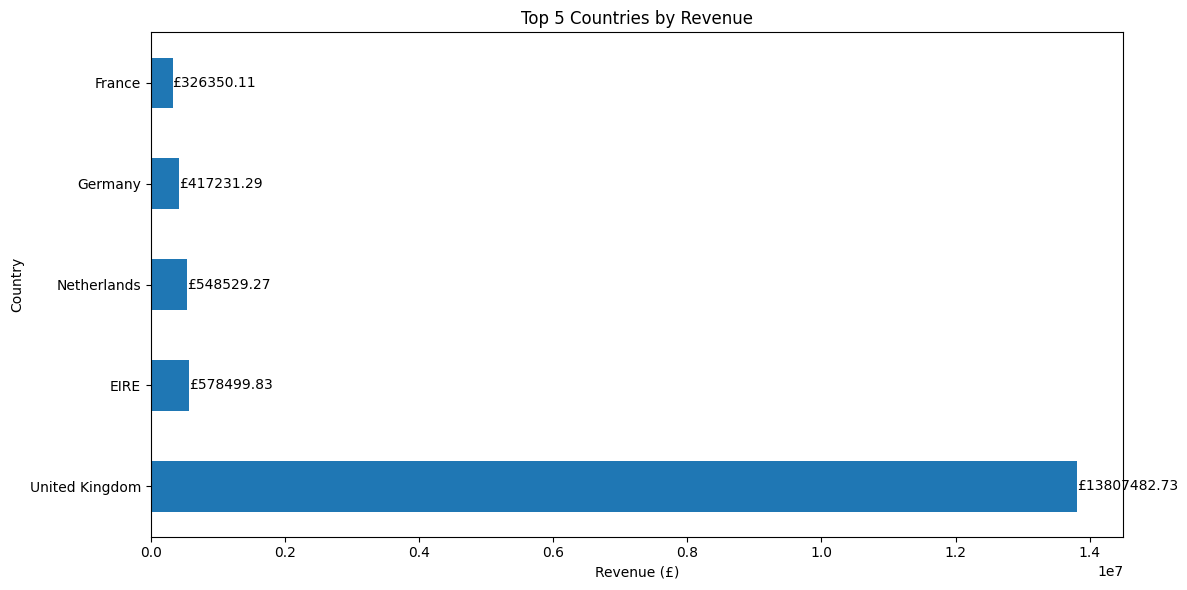

In [4]:
# list of countries in dataset
print(pd.DataFrame(sorted(df['Country'].unique()), columns=['Country']))
# countries by revenue
CountriesRevenue = df.groupby('Country')['Revenue'].sum().nlargest(5)
plt.figure(figsize=(12, 6))
CountriesRevenue.plot(kind='barh')
for index, value in enumerate(CountriesRevenue):
    plt.text(value, index, f'£{value:.2f}', va='center')
plt.title('Top 5 Countries by Revenue')
plt.xlabel('Revenue (£)')
plt.tight_layout()
plt.show()

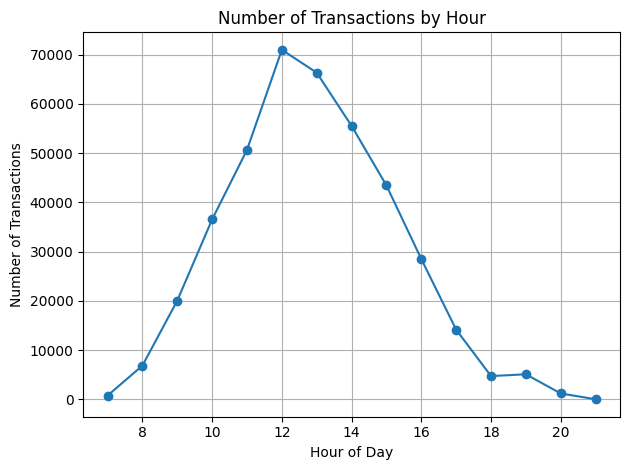

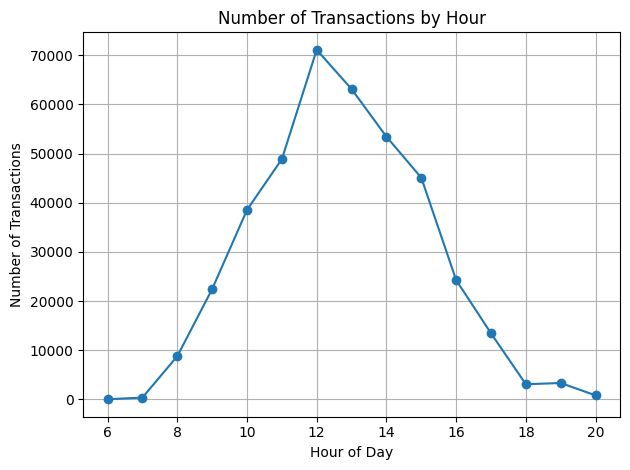

In [5]:
# visualize transactions by hour
HourlyTransactions = df2009_2010.groupby('TimeOfDay')['Invoice'].count()
HourlyTransactions.plot(kind='line', marker='o')
plt.title('Number of Transactions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.tight_layout()
plt.show()

HourlyTransactions = df2010_2011.groupby('TimeOfDay')['Invoice'].count()
HourlyTransactions.plot(kind='line', marker='o')
plt.title('Number of Transactions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.tight_layout()
plt.show()

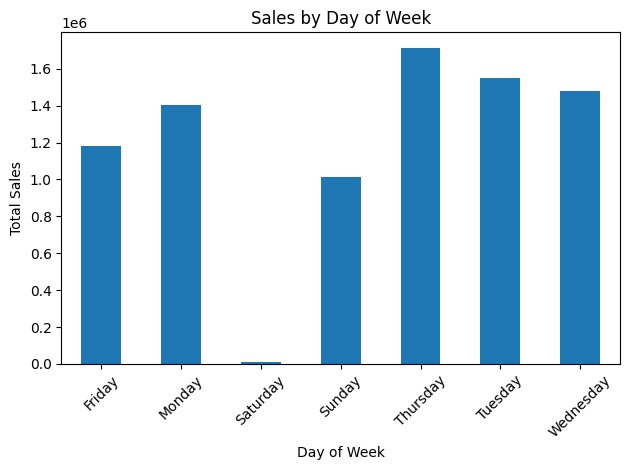

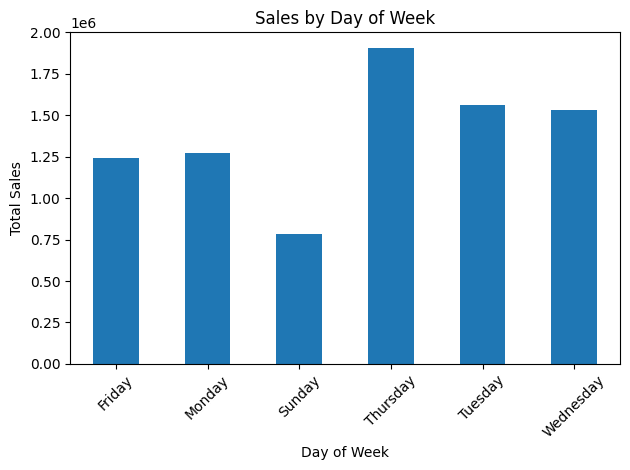

In [6]:
# visualize number of sales made according to day of week
DailySales = df2009_2010.groupby('DayOfWeek')['TotalSalesAmount'].sum()
DailySales.plot(kind='bar')
plt.title('Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

DailySales = df2010_2011.groupby('DayOfWeek')['TotalSalesAmount'].sum()
DailySales.plot(kind='bar')
plt.title('Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

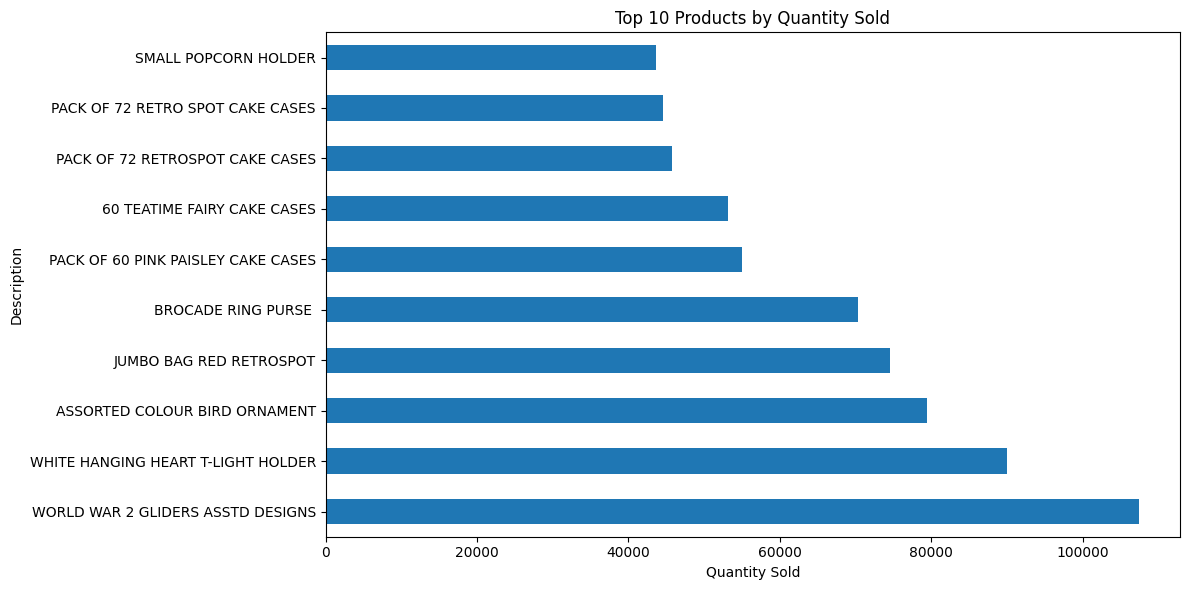

In [7]:
# determine top products sold
TopProducts = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
TopProducts.plot(kind='barh')
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Quantity Sold')
plt.tight_layout()
plt.show()

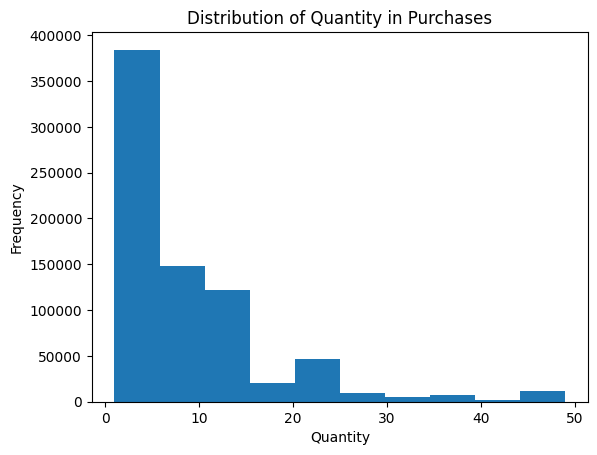

In [8]:
# distribution of quantity (purchases only, under 50)
plt.hist(df_purchases[df_purchases['Quantity'] < 50]['Quantity'])
plt.title('Distribution of Quantity in Purchases')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

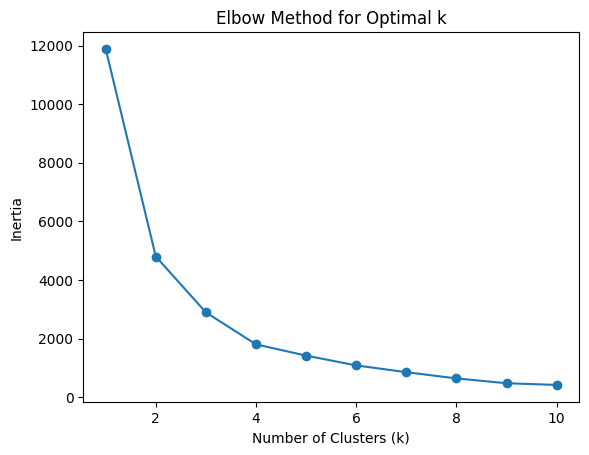

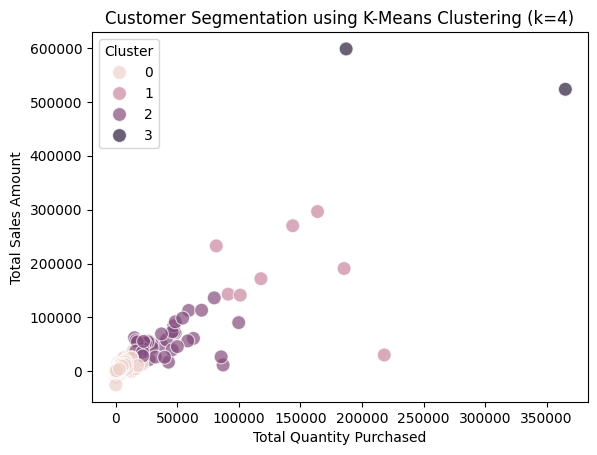

        Quantity  TotalSalesAmount
0    1171.448293       1985.037357
1  137893.750000     184688.346250
2   39069.511628      54878.308209
3  276165.000000     560780.805000


In [9]:
# clustering customers by sales/quantity purchased
customer_data = df.groupby('Customer ID').agg({
    'Quantity' : 'sum',
    'TotalSalesAmount': 'sum',
}).reset_index()

scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[['Quantity', 'TotalSalesAmount', ]])

# find best k with elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_data_scaled)
    inertia.append(kmeans.inertia_)
    
# show elbow plot
plt.plot(range(1, 11), inertia, marker = 'o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# elbow at k = 4
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)

# show clusters
sns.scatterplot(x='Quantity', y = 'TotalSalesAmount', hue = 'Cluster', data = customer_data, s = 100, alpha = 0.7)
plt.title(f'Customer Segmentation using K-Means Clustering (k={k})')
plt.xlabel('Total Quantity Purchased')
plt.ylabel('Total Sales Amount')
plt.legend(title='Cluster')
plt.show()
# average quantity and total sales by cluster
cluster_centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=['Quantity', 'TotalSalesAmount'])
print(cluster_centroids)

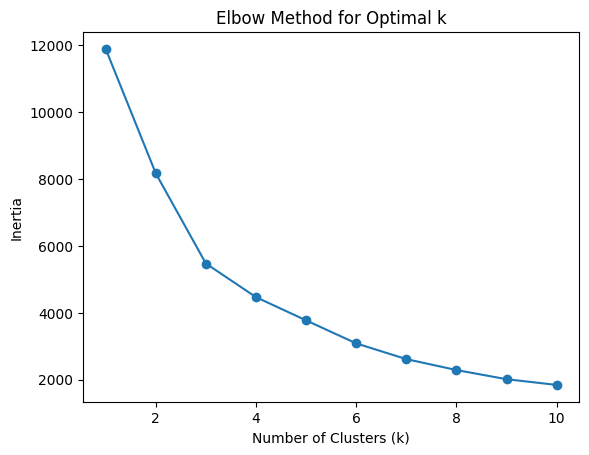

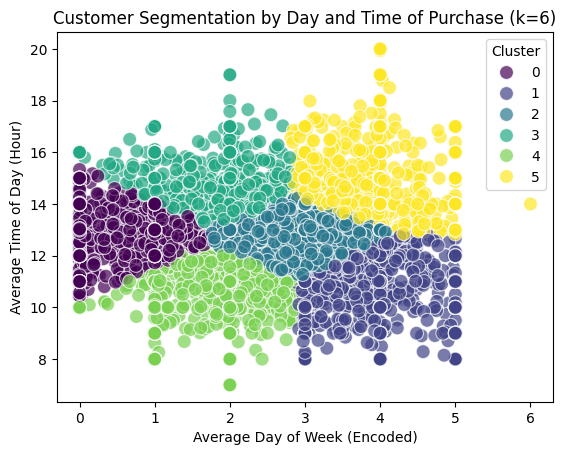

   DayOfWeek_Encoded  TimeOfDay DayOfWeek_Decoded
0           0.597604  12.870448            Monday
1           3.919853  10.730431          Thursday
2           2.825461  12.645565         Wednesday
3           1.808916  14.811358           Tuesday
4           1.826173  10.750618           Tuesday
5           3.890310  14.912293          Thursday


In [10]:
# cluster customers by day of week and time of purchases

# map DayOfWeek to numerical values
day_mapping = {'Sunday': 0, 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6}
df['DayOfWeek_Encoded'] = df['DayOfWeek'].map(day_mapping)

customer_data = df.groupby('Customer ID').agg({
    'DayOfWeek_Encoded': 'mean',  # Use the mean of the encoded day for each customer
    'TimeOfDay': 'mean'           # Average purchase time of day
}).reset_index()

scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[['DayOfWeek_Encoded', 'TimeOfDay']])

# find best k with elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_data_scaled)
    inertia.append(kmeans.inertia_)

# show elbow plot
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# elbow at k = 6
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)

# show clusters
sns.scatterplot(
    x='DayOfWeek_Encoded', 
    y='TimeOfDay', 
    hue='Cluster', 
    data=customer_data, 
    palette='viridis', 
    s=100, alpha=0.7
)
plt.title(f'Customer Segmentation by Day and Time of Purchase (k={k})')
plt.xlabel('Average Day of Week (Encoded)')
plt.ylabel('Average Time of Day (Hour)')
plt.legend(title='Cluster')
plt.show()

# Decode cluster centers to original scale
cluster_centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_), 
    columns=['DayOfWeek_Encoded', 'TimeOfDay']
)
cluster_centroids['DayOfWeek_Decoded'] = cluster_centroids['DayOfWeek_Encoded'].round().map({v: k for k, v in day_mapping.items()})
print(cluster_centroids)


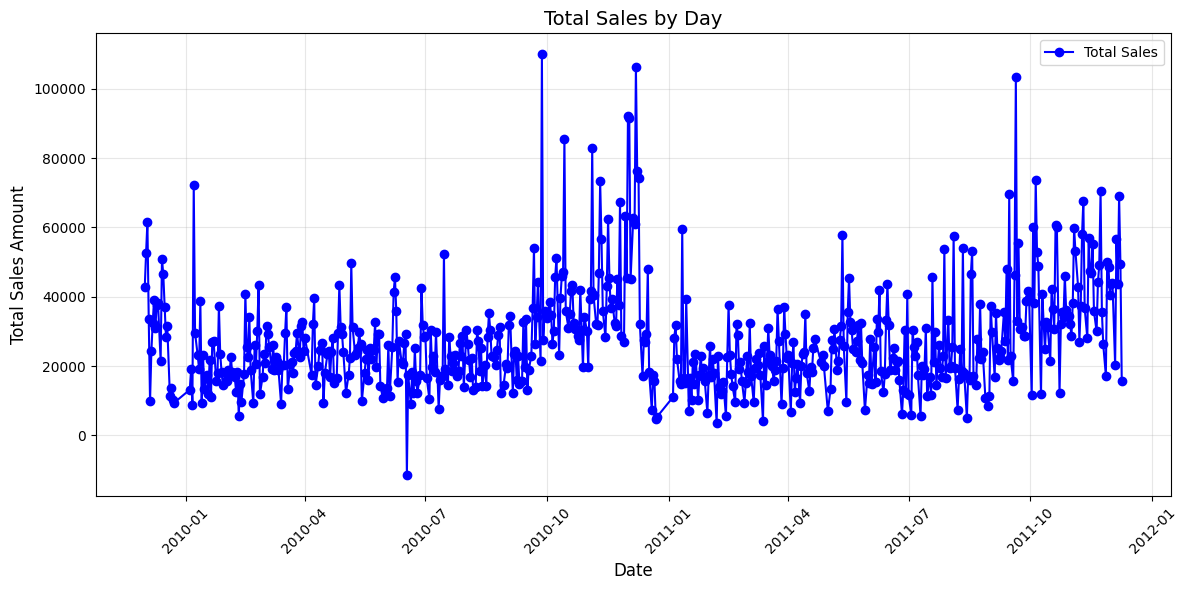

In [11]:
# total sales by day
df['Date'] = df['InvoiceDate'].dt.date
sales_by_day = df.groupby('Date')['TotalSalesAmount'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(sales_by_day['Date'], sales_by_day['TotalSalesAmount'], marker='o', color='blue', label='Total Sales')
plt.title('Total Sales by Day', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales Amount', fontsize=12)
plt.xticks(rotation=45)  
plt.grid(alpha=0.3)




plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# association rule mining for items purchased together
transactions = df.groupby('Invoice')['Description'].apply(list).reset_index()
te = TransactionEncoder()
te_data = te.fit(transactions['Description']).transform(transactions['Description'])
df_trans = pd.DataFrame(te_data, columns=te.columns_)

frequent_itemsets = apriori(df_trans, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6, num_itemsets=len(frequent_itemsets))
strong_rules = rules[rules['lift'] > 1]

In [13]:
multi_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) > 1)]
print(multi_itemsets)


      support                                           itemsets
440  0.012769  (60 TEATIME FAIRY CAKE CASES, 72 SWEETHEART FA...
441  0.012858  (60 TEATIME FAIRY CAKE CASES, PACK OF 60 DINOS...
442  0.016445  (60 TEATIME FAIRY CAKE CASES, PACK OF 60 PINK ...
443  0.010674  (60 TEATIME FAIRY CAKE CASES, PACK OF 72 RETRO...
444  0.010228  (PACK OF 72 SKULL CAKE CASES, 60 TEATIME FAIRY...
..        ...                                                ...
528  0.010429  (WOODEN FRAME ANTIQUE WHITE , WOOD 2 DRAWER CA...
529  0.010184  (WOODEN PICTURE FRAME WHITE FINISH, WOOD 2 DRA...
530  0.022350  (WOODEN PICTURE FRAME WHITE FINISH, WOODEN FRA...
531  0.010429  (WOODEN STAR CHRISTMAS SCANDINAVIAN, WOODEN HE...
532  0.012100  (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...

[93 rows x 2 columns]


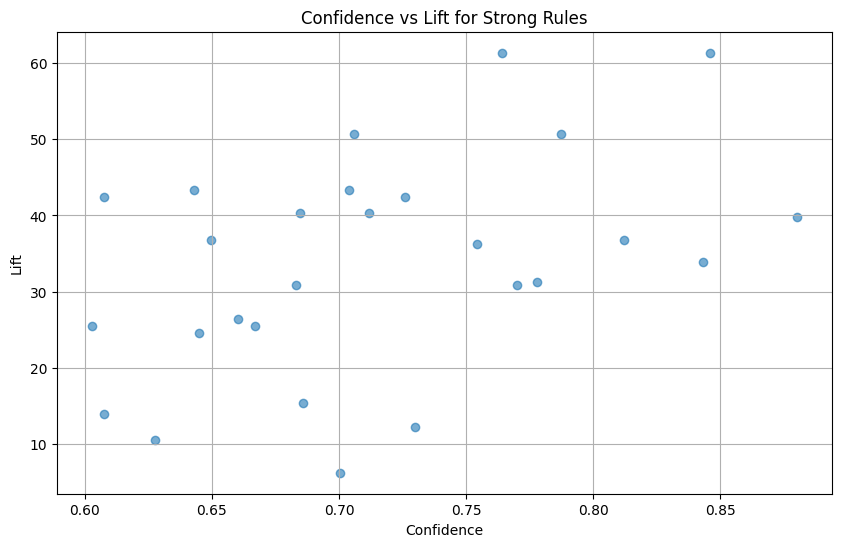

In [14]:
# Plot Confidence vs Lift
plt.figure(figsize=(10, 6))
plt.scatter(strong_rules['confidence'], strong_rules['lift'], alpha=0.6)
plt.title('Confidence vs Lift for Strong Rules')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.grid(True)
plt.show()

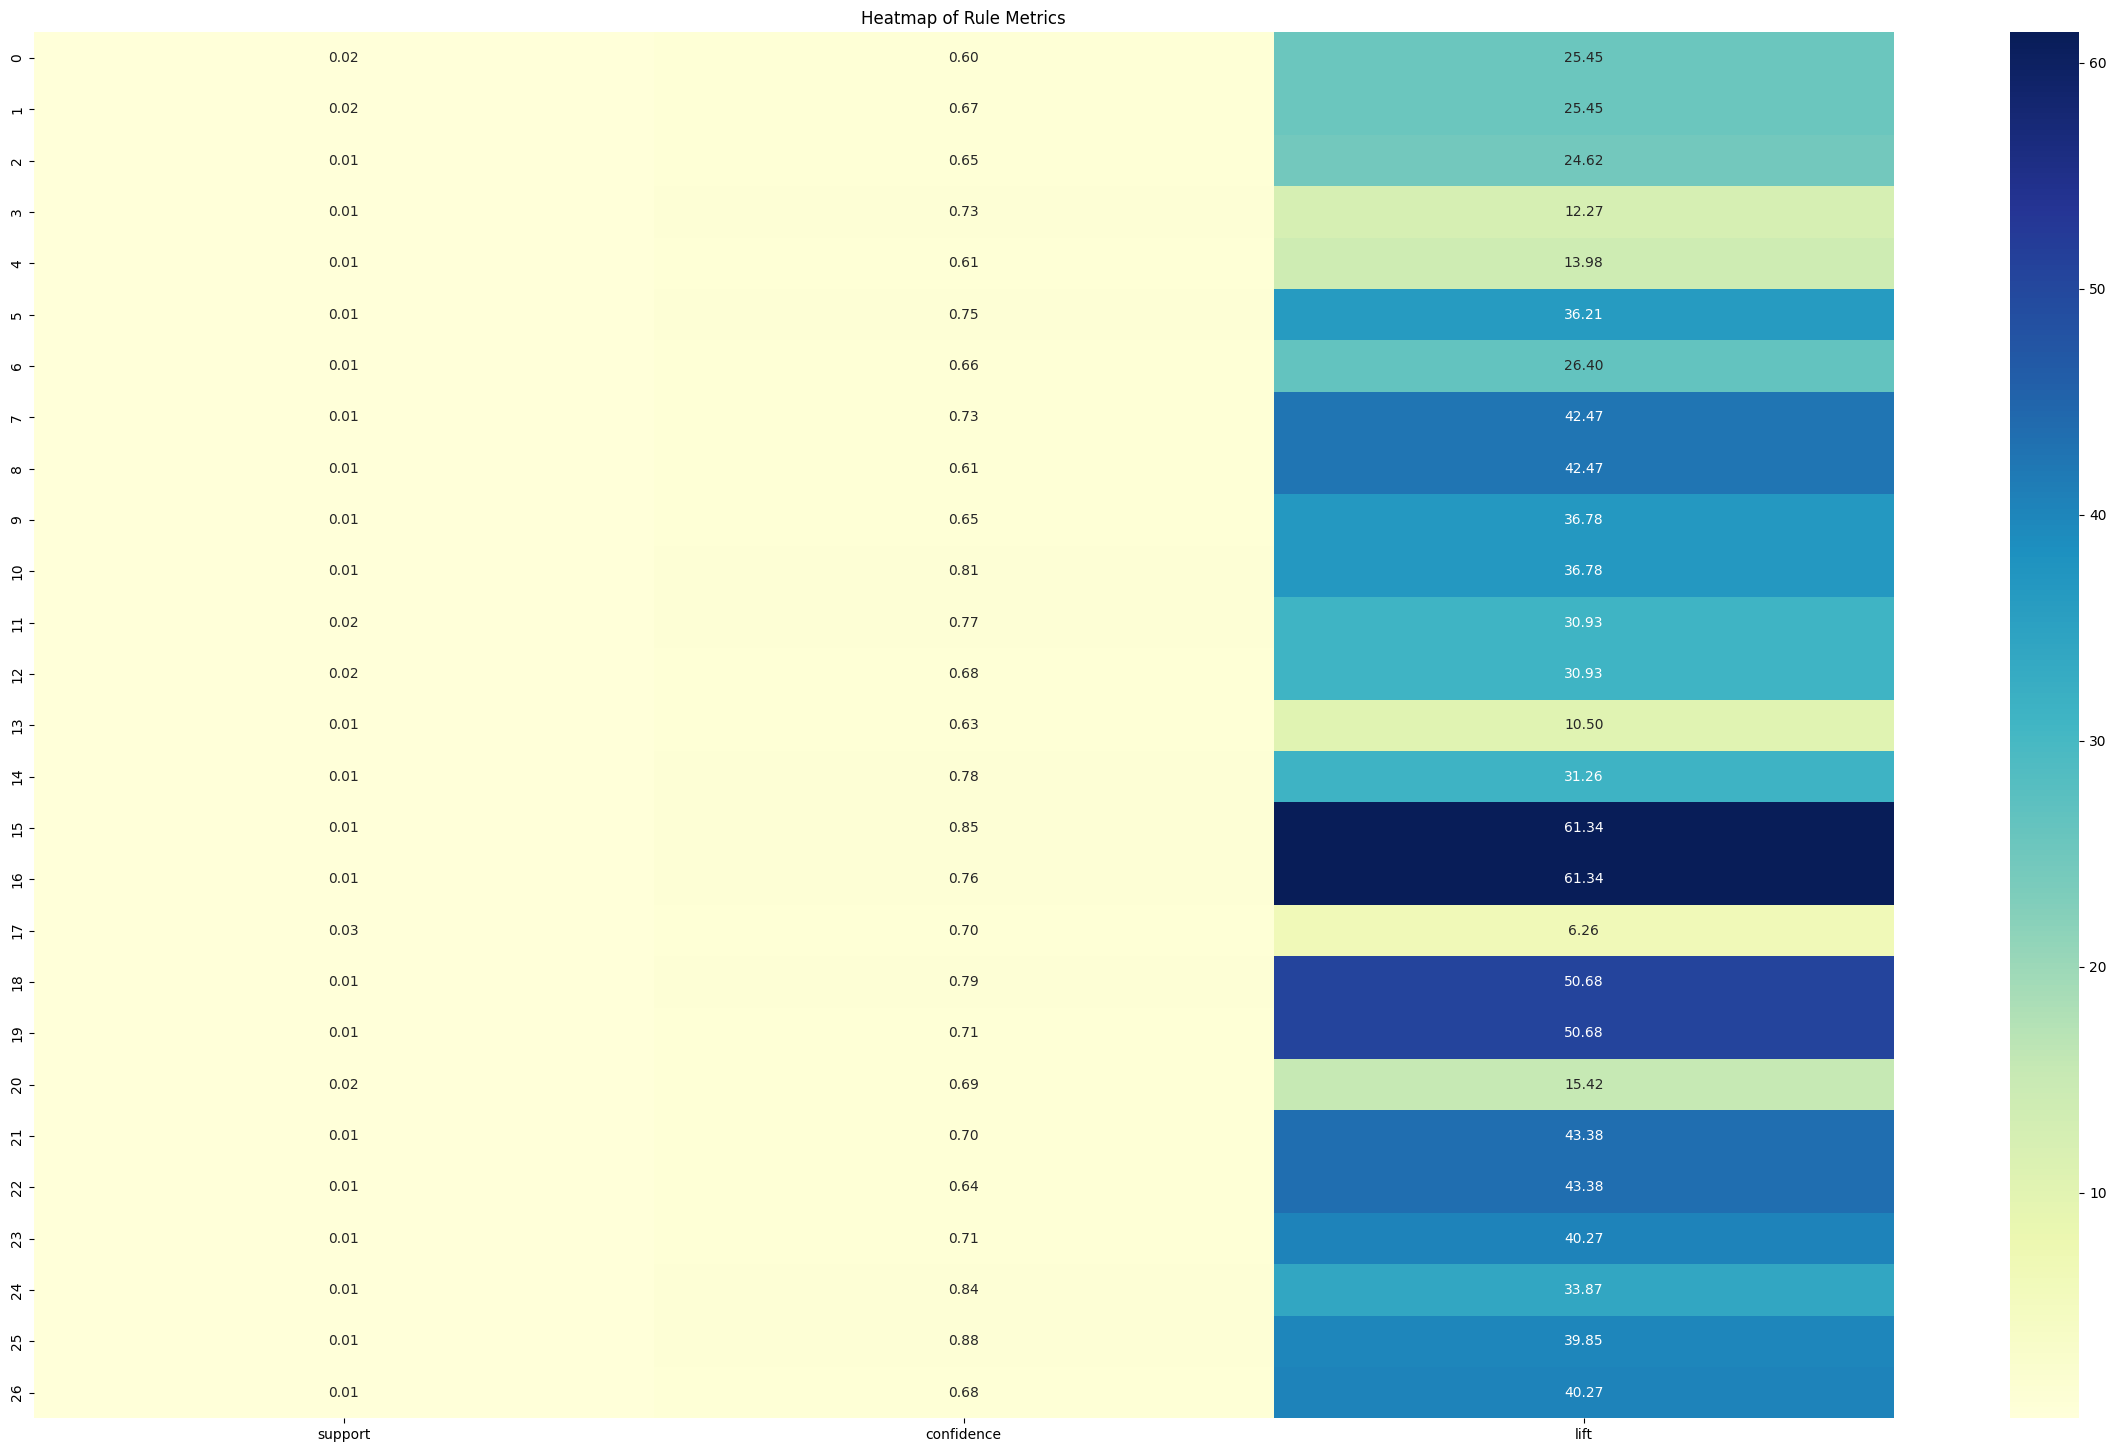

In [15]:
# heatmap of rule metrics
rule_metrics = strong_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
plt.figure(figsize=(30, 18))
sns.heatmap(rule_metrics[['support', 'confidence', 'lift']], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Heatmap of Rule Metrics')
plt.show()

In [16]:
# sort rules by lift and show top 10
top_rules = strong_rules.sort_values(by='lift', ascending=False).head(10)
print(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

                                          antecedents  \
16                        (POPPY'S PLAYHOUSE KITCHEN)   
15                       (POPPY'S PLAYHOUSE BEDROOM )   
19                    (SET/6 RED SPOTTY PAPER PLATES)   
18                      (SET/6 RED SPOTTY PAPER CUPS)   
22              (WOODEN HEART CHRISTMAS SCANDINAVIAN)   
21               (WOODEN STAR CHRISTMAS SCANDINAVIAN)   
8                 (GARDENERS KNEELING PAD KEEP CALM )   
7                (GARDENERS KNEELING PAD CUP OF TEA )   
23  (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...   
26                   (PINK REGENCY TEACUP AND SAUCER)   

                                          consequents   support  confidence  \
16                       (POPPY'S PLAYHOUSE BEDROOM )  0.010540    0.764136   
15                        (POPPY'S PLAYHOUSE KITCHEN)  0.010540    0.846154   
19                      (SET/6 RED SPOTTY PAPER CUPS)  0.010964    0.705882   
18                    (SET/6 RED SPOTTY PAPER PLATES)  0

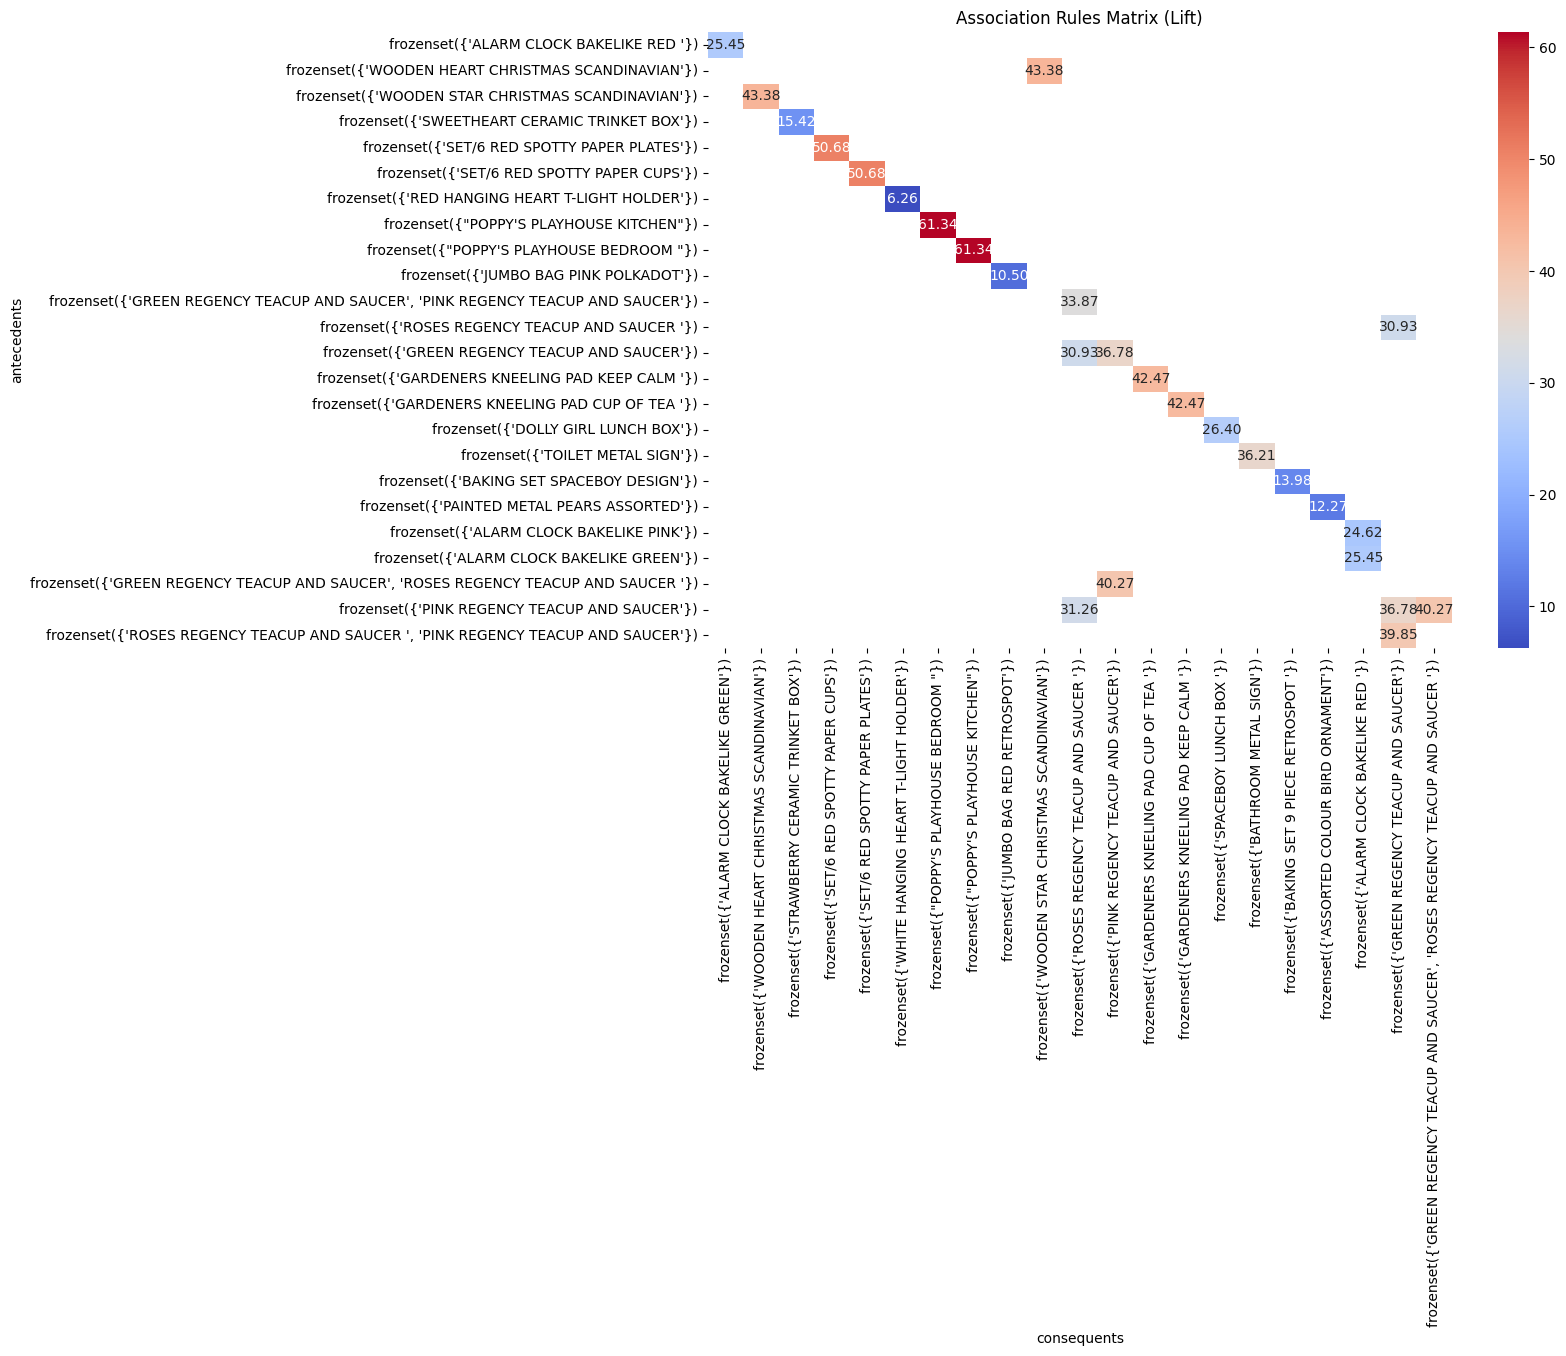

In [17]:
# plotting association rules as matrix plot
rules_matrix = strong_rules.pivot_table(index='antecedents', columns='consequents', values='lift', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(rules_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Association Rules Matrix (Lift)')
plt.show()

C:\Users\ethan\AppData\Local\Temp\ipykernel_18556\2381084782.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


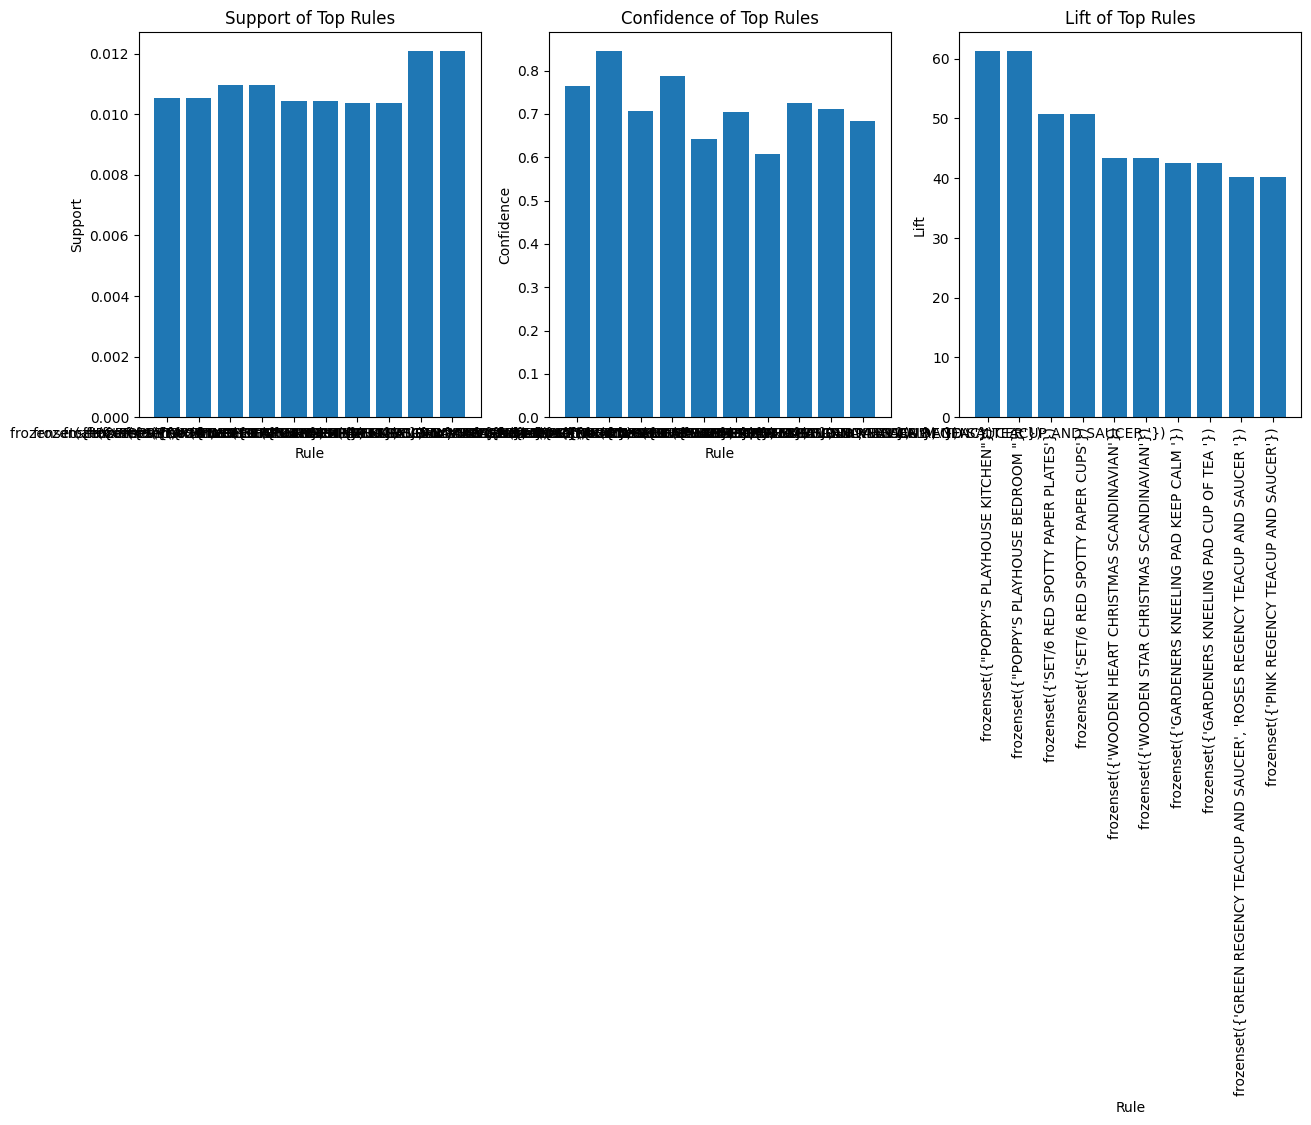

In [18]:
# bar plots for support, confidence, and lift of top rules
top_rules = strong_rules.sort_values(by='lift', ascending=False).head(10)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(top_rules['antecedents'].astype(str), top_rules['support'])
axes[0].set_title('Support of Top Rules')
axes[0].set_xlabel('Rule')
axes[0].set_ylabel('Support')

axes[1].bar(top_rules['antecedents'].astype(str), top_rules['confidence'])
axes[1].set_title('Confidence of Top Rules')
axes[1].set_xlabel('Rule')
axes[1].set_ylabel('Confidence')

axes[2].bar(top_rules['antecedents'].astype(str), top_rules['lift'])
axes[2].set_title('Lift of Top Rules')
axes[2].set_xlabel('Rule')
axes[2].set_ylabel('Lift')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [19]:
# customer session features
customer_sessions = df.groupby(['Customer ID', 'Invoice']).agg({
    'InvoiceDate': ['min', 'max'],
    'StockCode': 'count',
    'SessionDuration': 'max',
    'TimeOfDay': 'first',
    'DayOfWeek': 'first',
    'TotalSalesAmount': 'sum'
}).reset_index()

customer_sessions.columns = [
    'Customer ID', 'Invoice', 'Session_Start', 'Session_End', 
    'Items_Viewed', 'Session_Duration', 'TimeOfDay', 'DayOfWeek', 
    'Transaction_Amount'
]

# adding derived columns
customer_sessions['Made_Purchase'] = (customer_sessions['Transaction_Amount'] > 0).astype(int)
customer_sessions['Hour'] = customer_sessions['TimeOfDay']
customer_sessions['Day_Numeric'] = customer_sessions['DayOfWeek'].map({
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 
    'Friday': 4, 'Saturday': 5, 'Sunday': 6
})

In [20]:
# customer history features
customer_history = df.groupby('Customer ID').agg({
    'Invoice': 'count',
    'TotalSalesAmount': ['sum', 'mean'],
    'Quantity': ['sum', 'mean']
}).reset_index()

customer_history.columns = [
    'Customer ID', 'Previous_Purchases', 'Total_Spent', 
    'Avg_Transaction_Value', 'Total_Items', 'Avg_Items_Per_Purchase'
]

# merge customer history with session data
customer_sessions = customer_sessions.merge(customer_history, on='Customer ID', how='left')

In [21]:
# cart abandonment features
customer_sessions['Cart_Value'] = customer_sessions['Transaction_Amount']
customer_sessions['Items_In_Cart'] = customer_sessions['Items_Viewed']
customer_sessions['Is_Return_Customer'] = (customer_sessions['Previous_Purchases'] > 1).astype(int)
customer_sessions['Cart_Abandonment'] = (
    (customer_sessions['Items_In_Cart'] > 0) & (customer_sessions['Transaction_Amount'] == 0)
).astype(int)

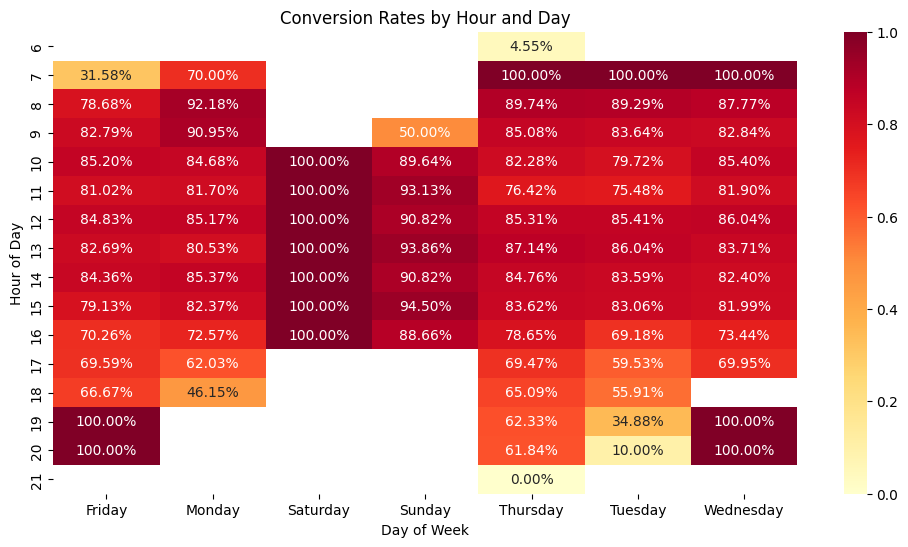

In [24]:
# customer purchase prediction

# define features and target
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


X_purchase = customer_sessions[[
    'Items_Viewed', 'Session_Duration', 'Hour', 'Day_Numeric',
    'Previous_Purchases', 'Avg_Transaction_Value', 'Avg_Items_Per_Purchase',
    'Cart_Value', 'Is_Return_Customer'
]]
y_purchase = customer_sessions['Made_Purchase']

# scale features
scaler = StandardScaler()
X_purchase_scaled = scaler.fit_transform(X_purchase)

X_train, X_test, y_train, y_test = train_test_split(X_purchase_scaled, y_purchase, test_size=0.2, random_state=42)

# train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# analyze purchase probabilities
purchase_probs = rf_model.predict_proba(X_test)[:, 1]
customer_segments = pd.DataFrame({
    'Purchase_Probability': purchase_probs,
    'Actual_Purchase': y_test
})

# conversion rate analysis
conversion_analysis = customer_sessions.groupby(['Hour', 'Day_Numeric'])['Made_Purchase'].agg([
    'mean', 'count'
]).reset_index()

conversion_analysis['Day'] = conversion_analysis['Day_Numeric'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
    4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})

# heatmap conversion rates
plt.figure(figsize=(12, 6))
pivot_data = conversion_analysis.pivot(index='Hour', columns='Day', values='mean')
sns.heatmap(pivot_data, annot=True, fmt='.2%', cmap='YlOrRd')
plt.title('Conversion Rates by Hour and Day')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.show()

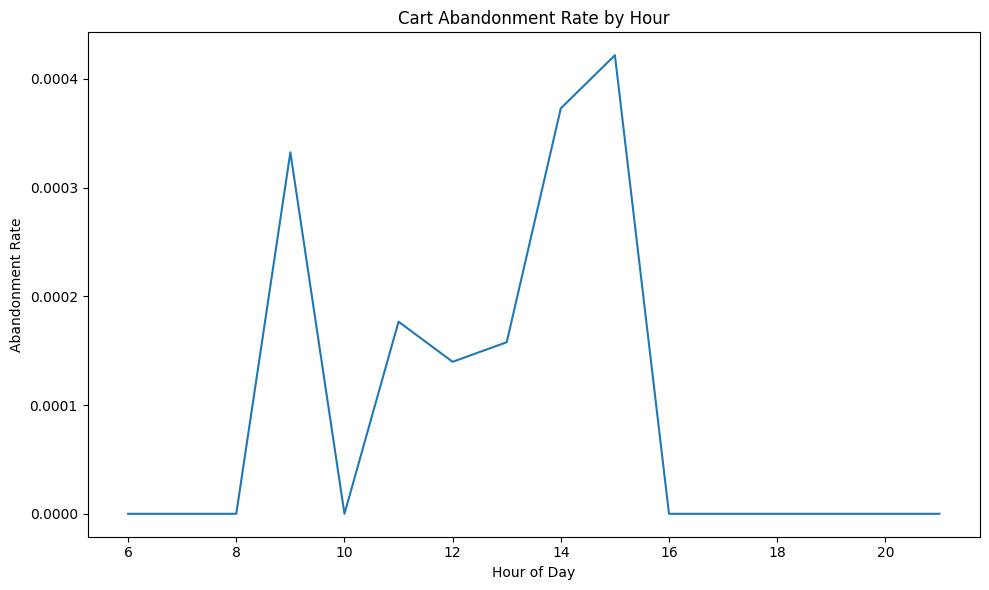

In [25]:
# cart abandonment prediction

# define features and target
X_abandonment = customer_sessions[[
    'Items_In_Cart', 'Cart_Value', 'Session_Duration', 
    'Hour', 'Day_Numeric', 'Is_Return_Customer'
]]
y_abandonment = customer_sessions['Cart_Abandonment']

X_abandonment_scaled = scaler.fit_transform(X_abandonment)

X_train, X_test, y_train, y_test = train_test_split(X_abandonment_scaled, y_abandonment, test_size=0.2, random_state=42)

# train model
cart_abandonment_model = RandomForestClassifier(n_estimators=100, random_state=42)
cart_abandonment_model.fit(X_train, y_train)

# cart abandonment behavior analysis
cart_analysis = customer_sessions[customer_sessions['Cart_Abandonment'] == 1].copy()

# segment cart values
if cart_analysis['Cart_Value'].nunique() > 1:
    cart_analysis['Cart_Value_Segment'] = pd.qcut(
        cart_analysis['Cart_Value'], 
        q=4, 
        labels=['Low Value', 'Medium-Low Value', 'Medium-High Value', 'High Value'],
        duplicates='drop'
    )
else:
    cart_analysis['Cart_Value_Segment'] = 'Single Value'

# plot abandonment rate
plt.figure(figsize=(10, 6))
abandonment_rate = customer_sessions.groupby('Hour')['Cart_Abandonment'].mean()
sns.lineplot(x=abandonment_rate.index, y=abandonment_rate.values)
plt.title('Cart Abandonment Rate by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Abandonment Rate')
plt.tight_layout()
plt.show()

In [27]:
# Predict future sales based on customer behavior

# sales features
from sklearn.ensemble import RandomForestRegressor


X_sales = customer_sessions[[
    'Items_In_Cart', 'Cart_Value', 'Session_Duration',
    'Hour', 'Day_Numeric', 'Is_Return_Customer'
]]
y_sales = customer_sessions['Cart_Value']

X_sales_scaled = scaler.fit_transform(X_sales)

# split for sales prediction
X_train_sales, X_test_sales, y_train_sales, y_test_sales = train_test_split(
    X_sales_scaled, y_sales, test_size=0.2, random_state=42
)

# train with random forest regressor
sales_model = RandomForestRegressor(n_estimators=100, random_state=42)
sales_model.fit(X_train_sales, y_train_sales)

# seasonal pattern and low sale periods
hourly_sales = customer_sessions.groupby('Hour')['Cart_Value'].agg(['mean', 'count'])
hourly_sales['total_sales'] = hourly_sales['mean'] * hourly_sales['count']

# low sales hours
low_sales_hours = hourly_sales[hourly_sales['total_sales'] <= hourly_sales['total_sales'].quantile(0.25)]


C:\Users\ethan\AppData\Local\Temp\ipykernel_18556\4028873398.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


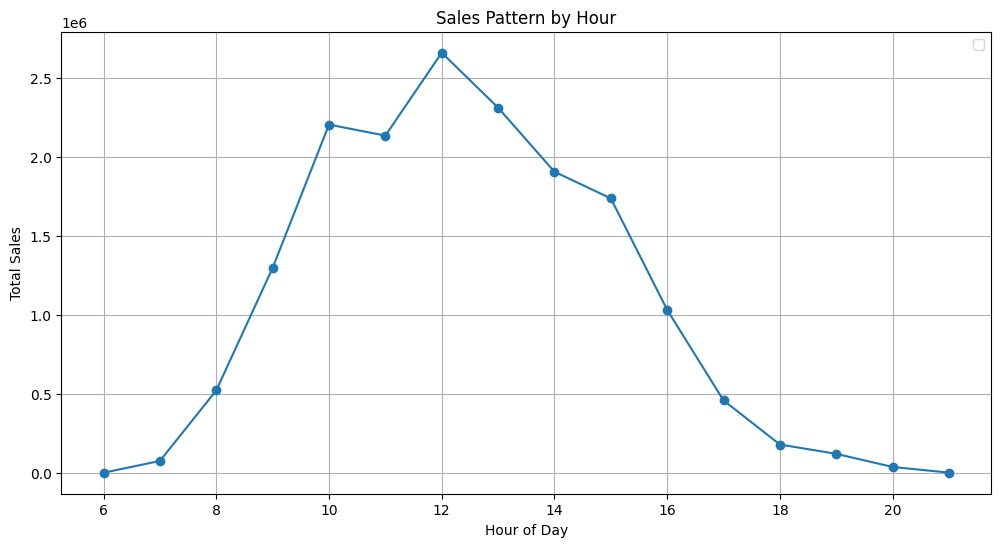


Discount Periods:
 Hour  Average_Sales  Transaction_Count Recommended_Discount
    6     -22.606818                 22               20-25%
    7     685.205741                108               10-15%
   20     366.944388                 98               10-15%
   21      -4.950000                  1               20-25%


In [28]:
# sales pattern by hour
plt.figure(figsize=(12, 6))
plt.plot(hourly_sales.index, hourly_sales['total_sales'], marker='o')
plt.title('Sales Pattern by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()

# discount time and percent discount
low_sales_summary = pd.DataFrame({
    'Hour': low_sales_hours.index,
    'Average_Sales': low_sales_hours['mean'],
    'Transaction_Count': low_sales_hours['count'],
    'Recommended_Discount': np.where(
        low_sales_hours['total_sales'] <= hourly_sales['total_sales'].quantile(0.1),
        '20-25%',
        '10-15%'
    )
})

print("\nDiscount Periods:")
print(low_sales_summary.to_string(index=False))